Dispositivo utilizado: cpu

INICIANDO COMPARAÇÃO - DATASET: MNIST

MNIST carregado com sucesso!
Tamanho do conjunto de treino: 10000
Tamanho do conjunto de teste: 10000
Número de classes: 10


######################################################################
TREINANDO AlexNet
######################################################################

AlexNet carregado com sucesso!
Parâmetros totais: 57,044,810
Parâmetros treináveis: 57,044,810
FLOPs: 0.71 GFLOPs
Época [1/1], Passo [50/79], Loss: 1.5787, Acc: 20.62%

Época 1 concluída em 836.82s
Loss médio: 1.7220, Acurácia: 36.32%


=== RESULTADOS DA AVALIAÇÃO ===
Acurácia: 70.35%
Precisão: 74.41%
Recall: 70.35%
F1-Score: 66.76%
Tempo de Inferência: 290.12s


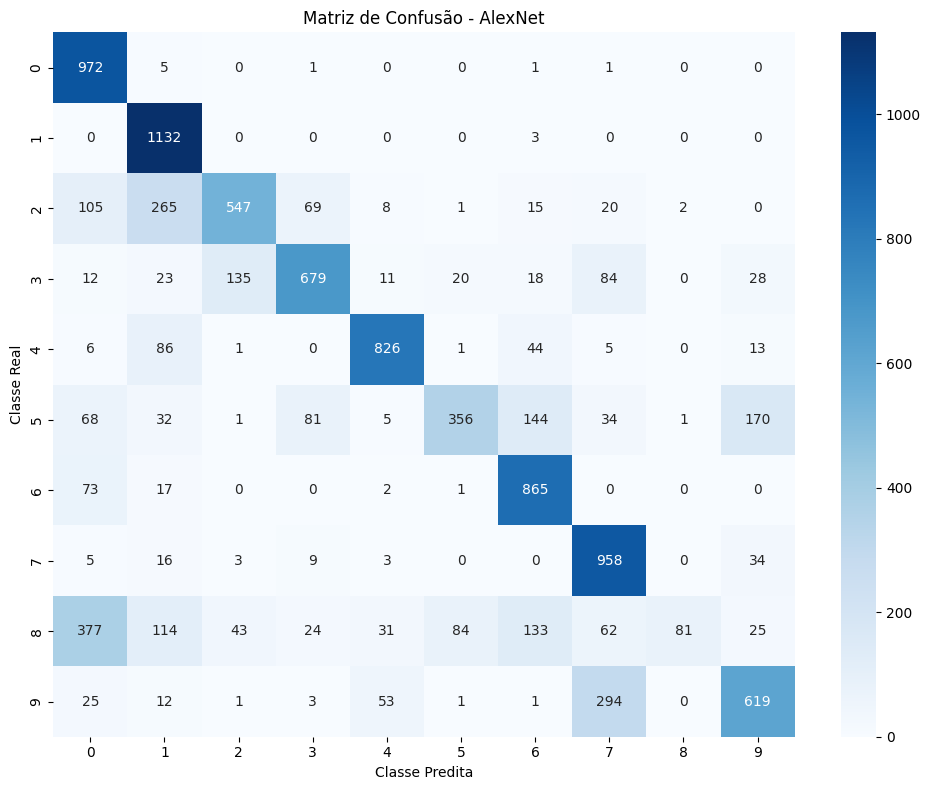



######################################################################
TREINANDO ResNet
######################################################################

ResNet carregado com sucesso!
Parâmetros totais: 23,528,522
Parâmetros treináveis: 23,528,522
FLOPs: 4.13 GFLOPs


In [ ]:
# ====================================================================
# VISÃO COMPUTACIONAL - PARTE 1
# Avaliação Comparativa de Modelos Pré-treinados em Classificação de Imagens
# ====================================================================

# Instalação de dependências necessárias
!pip install torch torchvision torchaudio --quiet
!pip install torchinfo ptflops scikit-learn matplotlib seaborn --quiet

# ====================================================================
# IMPORTAÇÃO DE BIBLIOTECAS
# ====================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import time
from torchinfo import summary
from ptflops import get_model_complexity_info

import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

# ====================================================================
# ETAPA 1: PREPARAÇÃO DOS DADOS
# ====================================================================

def prepare_datasets(dataset_name='MNIST', batch_size=128):
    """
    Prepara e carrega os datasets MNIST, CIFAR-10 ou Fashion-MNIST
    """
    if dataset_name == 'MNIST':
        # Transformações para MNIST (1 canal -> 3 canais para modelos pré-treinados)
        transform_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        transform_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
        num_classes = 10

        # Usar apenas um subset para treino rápido
        train_size = 10000
        train_dataset = torch.utils.data.Subset(train_dataset, range(train_size))

    elif dataset_name == 'CIFAR10':
        # Transformações para CIFAR-10
        transform_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        transform_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
        num_classes = 10

        # Usar apenas um subset para treino rápido
        train_size = 10000
        train_dataset = torch.utils.data.Subset(train_dataset, range(train_size))

    elif dataset_name == 'FashionMNIST':
        # Transformações para Fashion-MNIST
        transform_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        transform_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
        num_classes = 10

        # Usar apenas um subset para treino rápido
        train_size = 10000
        train_dataset = torch.utils.data.Subset(train_dataset, range(train_size))

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    print(f'\n{dataset_name} carregado com sucesso!')
    print(f'Tamanho do conjunto de treino: {len(train_dataset)}')
    print(f'Tamanho do conjunto de teste: {len(test_dataset)}')
    print(f'Número de classes: {num_classes}')

    return train_loader, test_loader, num_classes

# ====================================================================
# ETAPA 2 e 3: SELEÇÃO DOS MODELOS E FINE-TUNING
# ====================================================================

def load_model(model_name, num_classes):
    """
    Carrega modelos pré-treinados e adapta para fine-tuning
    """
    if model_name == 'AlexNet':
        model = models.alexnet(pretrained=True)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)

    elif model_name == 'ResNet':
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)

    elif model_name == 'MobileNet':
        model = models.mobilenet_v2(pretrained=True)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)

    model = model.to(device)
    print(f'\n{model_name} carregado com sucesso!')

    return model

def get_model_info(model, input_size=(3, 224, 224)):
    """
    Obtém informações sobre o modelo: parâmetros e FLOPs
    """
    # Número de parâmetros
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # FLOPs
    try:
        flops, params = get_model_complexity_info(model, input_size, as_strings=False,
                                                   print_per_layer_stat=False, verbose=False)
        flops_str = f"{flops / 1e9:.2f} GFLOPs"
    except:
        flops_str = "N/A"

    print(f'Parâmetros totais: {total_params:,}')
    print(f'Parâmetros treináveis: {trainable_params:,}')
    print(f'FLOPs: {flops_str}')

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'flops': flops_str
    }

# ====================================================================
# ETAPA 4: TREINAMENTO E AVALIAÇÃO
# ====================================================================

def train_model(model, train_loader, criterion, optimizer, num_epochs=1):
    """
    Treina o modelo
    """
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (i + 1) % 50 == 0:
                print(f'Época [{epoch+1}/{num_epochs}], Passo [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

        epoch_time = time.time() - start_time
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'\nÉpoca {epoch+1} concluída em {epoch_time:.2f}s')
        print(f'Loss médio: {epoch_loss:.4f}, Acurácia: {epoch_acc:.2f}%\n')

    return train_losses, train_accuracies

def evaluate_model(model, test_loader):
    """
    Avalia o modelo no conjunto de teste
    """
    model.eval()
    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    inference_time = time.time() - start_time

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'inference_time': inference_time,
        'all_preds': all_preds,
        'all_labels': all_labels
    }

    print(f'\n=== RESULTADOS DA AVALIAÇÃO ===')
    print(f'Acurácia: {accuracy*100:.2f}%')
    print(f'Precisão: {precision*100:.2f}%')
    print(f'Recall: {recall*100:.2f}%')
    print(f'F1-Score: {f1*100:.2f}%')
    print(f'Tempo de Inferência: {inference_time:.2f}s')

    return metrics

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """
    Plota a matriz de confusão
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.tight_layout()
    plt.show()

# ====================================================================
# PIPELINE COMPLETO
# ====================================================================

def run_comparison(dataset_name='MNIST', num_epochs=1, batch_size=128):
    """
    Executa comparação completa entre os modelos
    """
    print(f'\n{"="*70}')
    print(f'INICIANDO COMPARAÇÃO - DATASET: {dataset_name}')
    print(f'{"="*70}')

    # Preparar dados
    train_loader, test_loader, num_classes = prepare_datasets(dataset_name, batch_size)

    # Definir classes para visualização
    if dataset_name == 'MNIST':
        class_names = [str(i) for i in range(10)]
    elif dataset_name == 'CIFAR10':
        class_names = ['avião', 'carro', 'pássaro', 'gato', 'cervo',
                      'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']
    elif dataset_name == 'FashionMNIST':
        class_names = ['Camiseta', 'Calça', 'Pulôver', 'Vestido', 'Casaco',
                      'Sandália', 'Camisa', 'Tênis', 'Bolsa', 'Bota']

    # Modelos a comparar
    model_names = ['AlexNet', 'ResNet', 'MobileNet']
    results = {}

    for model_name in model_names:
        print(f'\n\n{"#"*70}')
        print(f'TREINANDO {model_name}')
        print(f'{"#"*70}')

        # Carregar modelo
        model = load_model(model_name, num_classes)

        # Obter informações do modelo
        model_info = get_model_info(model)

        # Configurar otimizador e loss
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Treinar
        train_losses, train_accuracies = train_model(model, train_loader, criterion,
                                                     optimizer, num_epochs)

        # Avaliar
        metrics = evaluate_model(model, test_loader)

        # Salvar resultados
        results[model_name] = {
            'model_info': model_info,
            'metrics': metrics,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies
        }

        # Plotar matriz de confusão
        plot_confusion_matrix(metrics['all_labels'], metrics['all_preds'],
                            class_names, model_name)

    # ====================================================================
    # ETAPA 5: ANÁLISE COMPARATIVA
    # ====================================================================

    print(f'\n\n{"="*70}')
    print(f'ANÁLISE COMPARATIVA - {dataset_name}')
    print(f'{"="*70}\n')

    # Tabela comparativa
    print(f'{"Modelo":<15} {"Acurácia":<12} {"Precisão":<12} {"Recall":<12} {"F1-Score":<12} {"Tempo Inf.(s)":<15}')
    print("-" * 90)
    for model_name, data in results.items():
        m = data['metrics']
        print(f'{model_name:<15} {m["accuracy"]*100:<11.2f}% {m["precision"]*100:<11.2f}% '
              f'{m["recall"]*100:<11.2f}% {m["f1_score"]*100:<11.2f}% {m["inference_time"]:<15.2f}')

    print(f'\n{"Modelo":<15} {"Parâmetros Totais":<20} {"Parâmetros Treináveis":<25} {"FLOPs":<15}')
    print("-" * 90)
    for model_name, data in results.items():
        info = data['model_info']
        print(f'{model_name:<15} {info["total_params"]:<20,} {info["trainable_params"]:<25,} {info["flops"]:<15}')

    # Gráficos comparativos
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Acurácia
    accuracies = [results[m]['metrics']['accuracy']*100 for m in model_names]
    axes[0, 0].bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0, 0].set_title('Acurácia (%)')
    axes[0, 0].set_ylim([0, 105])
    axes[0, 0].grid(axis='y', alpha=0.3)

    # F1-Score
    f1_scores = [results[m]['metrics']['f1_score']*100 for m in model_names]
    axes[0, 1].bar(model_names, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0, 1].set_title('F1-Score (%)')
    axes[0, 1].set_ylim([0, 105])
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Tempo de Inferência
    inf_times = [results[m]['metrics']['inference_time'] for m in model_names]
    axes[1, 0].bar(model_names, inf_times, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1, 0].set_title('Tempo de Inferência (s)')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Número de Parâmetros
    params = [results[m]['model_info']['total_params']/1e6 for m in model_names]
    axes[1, 1].bar(model_names, params, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1, 1].set_title('Número de Parâmetros (Milhões)')
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Relatório final
    print(f'\n{"="*70}')
    print('CONCLUSÕES E RECOMENDAÇÕES')
    print(f'{"="*70}\n')

    best_accuracy = max(model_names, key=lambda m: results[m]['metrics']['accuracy'])
    best_efficiency = min(model_names, key=lambda m: results[m]['metrics']['inference_time'])
    best_balance = max(model_names, key=lambda m: results[m]['metrics']['f1_score'] /
                      (results[m]['model_info']['total_params'] / 1e6))

    print(f'✓ Melhor Acurácia: {best_accuracy} ({results[best_accuracy]["metrics"]["accuracy"]*100:.2f}%)')
    print(f'✓ Mais Eficiente: {best_efficiency} ({results[best_efficiency]["metrics"]["inference_time"]:.2f}s)')
    print(f'✓ Melhor Equilíbrio (F1/Parâmetros): {best_balance}')

    print(f'\n{"="*70}\n')

    return results

# ====================================================================
# EXECUÇÃO DO EXPERIMENTO
# ====================================================================

# Escolha o dataset: 'MNIST', 'CIFAR10', ou 'FashionMNIST'
dataset = 'MNIST'  # Altere aqui para testar outros datasets

# Execute a comparação (1 época e batch maior para execução muito mais rápida)
results = run_comparison(dataset_name='MNIST', num_epochs=1, batch_size=128)

# Para executar em todos os datasets, descomente as linhas abaixo:
# results_mnist = run_comparison(dataset_name='MNIST', num_epochs=1, batch_size=128)
# results_cifar = run_comparison(dataset_name='CIFAR10', num_epochs=1, batch_size=128)
# results_fashion = run_comparison(dataset_name='FashionMNIST', num_epochs=1, batch_size=128)